## Plot the mask we copied from Ben Barton and see how this relates to our work

In [1]:
# import packages and functions
# define figure path to save lots of figures - we choose relevant ones to talk about
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import gzip

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean
from scipy.ndimage import binary_dilation
from matplotlib.lines import Line2D

import h5py
from scipy.io import loadmat
from scipy.io import savemat

sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from get_Jterms import *  # this will also set up the grid should be

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
from matplotlib.colors import ListedColormap as ListedColormap

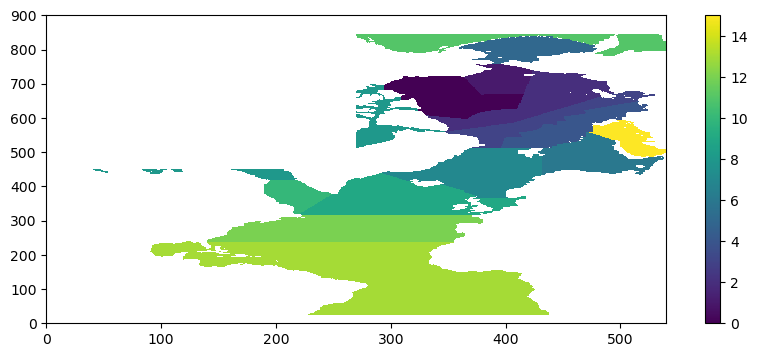

In [3]:
# load the whole Basin mask
# copy over the mask
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan


# extend the Barents Sea up to the gate between NZ--RU
mskBasin[mymsk == 1] = 6

ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

ind2d = mskBasin.reshape(364500)
ind2d.shape
# iBarentsS2D = np.where(ind2d == 7)[0]

mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

ind2d_wet = ind2d[iwetC2d]
iwet_BarentsS2D = np.where(ind2d_wet == 6)[0]
iwet_mine = iwet_BarentsS2D
imask = np.where(ind2d == -1)[0]
iwet_mymsk = np.where(ind2d_wet == 6)[0]

In [4]:
# define the gateways
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_nzru = np.full((5),37)
y_nzru = np.arange(460,465,1)

gates = np.full(mskBasin.shape,np.nan)
gates[y_bso,x_bso] = 1
gates[y_sfj,x_sfj] = 2
gates[y_fjnz,x_fjnz] = 3
gates[y_nzru,x_nzru] = 4

In [5]:
barton_mask = np.load("poly_mask.npy")

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

In [6]:
barton_mask[barton_mask == 0] = np.nan

## get the sea ice edge

In [7]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
# allyears = np.arange(2003,2018,1)

In [8]:
allyears = np.array([2007,2016])

In [9]:
# define the sea ice extent for March

# we should also load the mean sea ice edge so we can plot this on bathymetry with the gates
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears),3,ny,nx))

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 

    # loop through JFM for this year
    for m in range(3):
        march_tsstr = tsstr[m]
    
        # read the fldList
        file_name = 'state_2d_set1'
        meta_state_2d_set1 = parsemeta(dirState + file_name + "." + march_tsstr + ".meta")
        fldlist = np.array(meta_state_2d_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])

    
    
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        read = int(tsstr[2])  # march
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea = np.reshape(SIareai,(ny,nx))#*mymsk  # fraction of SIarea    
        SIareas[iy,m] = SIarea

    iy += 1

2007
2016


In [10]:
SIareas.shape
np.nanmean(SIareas[0], axis=0).shape

(1350, 270)

In [11]:
# define the ice edge to plot
SI_early_tr = get_aste_tracer(np.nanmean(SIareas[0], axis=0),nfx,nfy)[0]     # monthly average for first year
SI_late_tr = get_aste_tracer(np.nanmean(SIareas[1], axis=0),nfx,nfy)[0]      # monthly JFM average for second year

mymsk_tr = np.where(np.isnan(mymsk), 0, mymsk)

# Step 1: Get land mask on tracer grid
landmask_tr = get_aste_tracer(landmsk, nfx, nfy)[0] > 0  # Boolean mask where land is True

# Step 2: Expand land by 1 grid cell in all directions
landbuffer_tr = binary_dilation(landmask_tr, iterations=1)

SI_early_tr_masked = np.where(landbuffer_tr, np.nan, SI_early_tr)
SI_late_tr_masked  = np.where(landbuffer_tr, np.nan, SI_late_tr)

# get the SST = 2 degree contour from avg temperature field

In [12]:
times = {}
times["2007"] = np.arange(1,13,1)   # write all the months for this example 5-year period
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

times = {}
times["2016"] = np.arange(1,13,1)   # write all the months for this example 5-year period
tsstr2,datetimes2 = get_tsteps(times,fnames,dt_aste,startyr,1,1)

In [13]:
THETA = np.zeros((len(tsstr)+len(tsstr2),nz,ny,nx))
# tsstr.shape

In [14]:
# load the SST for the two years -- FIX

# do sea ice area, SST, SSS reading the files
# read in the surface salt flux values

#all 2007
for t in range(len(tsstr)):
    file_name = 'state_3d_set1'
    meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETAi,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    THETAi = THETAi.reshape(nz,ny,nx)

    # set in the larger array
    THETA[t] = THETAi

#all 2016
for t in range(len(tsstr2[:-1])):
    file_name = 'state_3d_set1'
    meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    t2 = int(tsstr2[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETAi,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    THETAi = THETAi.reshape(nz,ny,nx)

    # set in the larger array
    THETA[t+12] = THETAi

# do the time averaging
THETA1 = np.nanmean(THETA[:12],axis=0) #* hfC
THETA2 = np.nanmean(THETA[12:],axis=0) #* hfC

In [15]:
SST1 = THETA1[0]
SST2 = THETA2[0]

## plot a big map so we can look at this

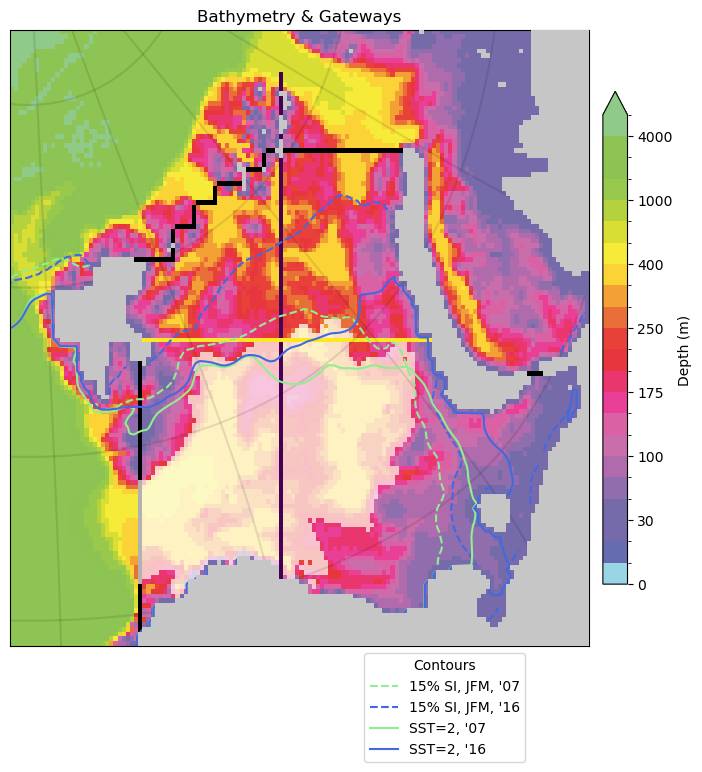

In [16]:
# plot both of these to look at where this is
# --- Bathymetry Colormap ---
colors = ['#7fcce0', '#3f479b', '#544596', '#534694', '#754898', '#9b4696', '#bd4896',
          '#d13b8d', '#e50f7c', '#e4034b', '#e3030e', '#e11108', '#e34b05', '#f18901',
          '#fcc903', '#f5e707', '#cfd600', '#a2c60e', '#7ebc20', '#6fb528', '#72b628', '#74bd6b']
bounds = [0, 10, 20, 30, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
          400, 500, 750, 1000, 1500, 2000, 4000, 6000]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

land_data = get_aste_tracer(landmsk, nfx, nfy)[0]
lon = get_aste_tracer(mygrid['XC'],nfx,nfy)[0]
lat = get_aste_tracer(mygrid['YC'],nfx,nfy)[0]

# --- Figure Setup ---
fig, ax0 = plt.subplots(figsize=(9, 8))

# ========== Bathymetry ==========
depth_data = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
pc = ax0.pcolormesh(depth_data, cmap=cmap, norm=norm, alpha=0.8)
ax0.pcolormesh(land_data, cmap="Greys", zorder=7, vmin=0, vmax=6)
ax0.contour(lat, levels=np.arange(70, 90, 5), colors="k", alpha=.1)
ax0.contour(lon, levels=np.arange(10, 80, 20), colors="k", alpha=.1)
ax0.contour(SI_early_tr_masked, levels=[0.15], colors='lightgreen',
            linewidths=1.5, linestyles='--')
ax0.contour(SI_late_tr_masked, levels=[0.15], colors='royalblue',
            linewidths=1.5, linestyles='--')

# Plot gateways
black_cmap = ListedColormap(['black'])
ax0.pcolormesh(get_aste_tracer(gates, nfx, nfy)[0], cmap=black_cmap)
# ax0.pcolormesh(get_aste_tracer(bit_mask, nfx, nfy)[0], cmap=black_cmap,
#                zorder=2, vmin=0.5, vmax=1.2)

# Colorbar
cb0 = fig.colorbar(pc, ax=ax0, orientation='vertical',
                   label="Depth (m)", extend="max", shrink=0.8, pad=0.02,
                   boundaries=bounds)

# Formatting
ax0.set_xlim(400, 540)
ax0.set_ylim(430, 560)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title("Bathymetry & Gateways", fontsize=12)

# add the mask we did for Barton
ax0.pcolormesh(get_aste_tracer(barton_mask,nfx,nfy)[0],cmap="Greys",alpha=0.7)


# add the cross-sectional terms (may use later)
y_sample = np.arange(435,551,1)
x_sample = np.full(y_sample.shape,465)
x_cross = np.arange(430,505,1)
y_cross = np.full(x_cross.shape,494)
sample_cross = np.full((900,540),np.nan)
sample_cross[y_sample,x_sample]= 1
sample_cross[y_cross,x_cross]= 3
sample_cross = aste_tracer2compact(sample_cross,nfx,nfy)[0]
plt.pcolormesh(get_aste_tracer(sample_cross,nfx,nfy)[0])


# plot the avg winter sea ice extent for the two layers years (2007 and 2016)
cs1 = ax0.contour(get_aste_tracer(SST1, nfx, nfy)[0], levels=[2], colors="lightgreen", linestyles="-", linewidths=1.5)
cs2 = ax0.contour(get_aste_tracer(SST2, nfx, nfy)[0], levels=[2], colors="royalblue", linestyles="-", linewidths=1.5)

# Legend for the JFM sea ice extent
legend_elements = [
    Line2D([0], [0], color='lightgreen', linestyle='--', linewidth=1.5,
           label="15% SI, JFM, '07"),
    Line2D([0], [0], color='royalblue', linestyle='--', linewidth=1.5,
           label="15% SI, JFM, '16"),
    Line2D([0], [0], color='lightgreen', linestyle='-', linewidth=1.5,
           label="SST=2 '07"),
    Line2D([0], [0], color='royalblue', linestyle='-', linewidth=1.5,
           label="SST=2, '16"),
]

labels = [
    "15% SI, JFM, '07",
    "15% SI, JFM, '16",
    "SST=2, '07",
    "SST=2, '16"
]

ax0.legend(handles=legend_elements, labels=labels, loc='lower left',
           bbox_to_anchor=(.6, -.2), fontsize=10,
           frameon=True, title='Contours')

# plot the avg contour for surface 2-deg C for the two layers years

plt.show()

# I think we want to compare both the WMT within the Barton box and North of it for each of the two years

## load the layers output which we generated for 2007 within the Barton box

In [17]:
# I think what we should try to do is fully delve into this and decide what is happening differently in this box

# neither year will have much interaction with the sea ice

# I think it will be faster to do this without layers and just use the regular ASTE
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2007"] = np.arange(1,13,1)
times["2008"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

AB_gT=0
AB_gS=0

tsteps = len(datetimes)-1
tsteps

12

In [18]:
# set the mask we want to use
mymsk = barton_mask
iB = 6 # redundant, but we use for the Barents Sea
titlestr = "AW contrib region "  # for plotting so we know and save correctly

In [19]:
# set a larger array for one year of the terms
nS,nT = 112,112
vol_mesh_all_2007 = np.zeros((tsteps,nS,nT))
JtermsT_all_2007 = np.zeros((tsteps,5,nS,nT))  # recall this is in the format tend, adv, df, kpp, and surface
JtermsS_all_2007 = np.zeros((tsteps,5,nS,nT))
JtermsT_nn_all_2007 = np.zeros((tsteps,5,nS,nT))
JtermsS_nn_all_2007 = np.zeros((tsteps,5,nS,nT))

vol = np.tile(mygrid['DXG'][np.newaxis,:,:],(50,1,1)) * np.tile(mygrid['DYG'][np.newaxis,:,:],(50,1,1)) * DRF3d

In [70]:
dstart = 0
dterm = 50      # for all sea
for i in range(len(datetimes)-1):
    print(datetimes[i])
    tsstrhere = tsstr[i:i+2]
    datetimeshere = datetimes[i:i+2]
    dt = datetimes[i+1]-datetimes[i]
    dt = dt.total_seconds()
    t2 = int(tsstr[i+1])

    # run the function - check if this works
    vol_mesh,JtermsT,JtermsS,JtermsT_nn,JtermsS_nn,a,b = get_Jterms(fnames,tsstrhere,datetimeshere,dt,t2,mymsk,iB,RAC,RAC3,myparms,dstart,dterm)

    vol_mesh_all_2007[i] = vol_mesh
    JtermsT_all_2007[i] = JtermsT
    JtermsS_all_2007[i] = JtermsS
    JtermsT_nn_all_2007[i] = JtermsT_nn
    JtermsS_nn_all_2007[i] = JtermsS_nn

2007-01-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -2.558867439239577e-05 Sv/PSU
doing JtermsS
total residual -9.275957733758398e-11 Sv/degC
doing not normalized J terms
total residual -2.558867439239577e-05 Sv
total residual -9.275957733758398e-11 Sv
2007-02-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -0.0029194574324155733 Sv/PSU
doing JtermsS
total residual -1.1481743944620993e-10 Sv/degC
doing not normalized J terms
total residual -0.0029194574324155733 Sv
total residual -1.1481743944620993e-10 Sv
2007-03-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -0.013032726848904972 Sv/PSU
doing JtermsS
total residual -6.49998283038878e-11 Sv/degC
doing not normalized J terms
total residual -0.013032726848904972 Sv
total residua

In [58]:
# can I also create the 2016 budget here? not sure if memory available
nS,nT = 112,112
vol_mesh_all_2016 = np.zeros((tsteps,nS,nT))
JtermsT_all_2016 = np.zeros((tsteps,5,nS,nT))  # recall this is in the format tend, adv, df, kpp, and surface
JtermsS_all_2016 = np.zeros((tsteps,5,nS,nT))
JtermsT_nn_all_2016 = np.zeros((tsteps,5,nS,nT))
JtermsS_nn_all_2016 = np.zeros((tsteps,5,nS,nT))

In [105]:
times = {}
times["2016"] = np.arange(1,13,1)
times["2017"] = np.array([1])

# the filenames we want for 2014
tsstr16,datetimes16 = get_tsteps(times,fnames,dt_aste,startyr,1,1)

dstart = 0
dterm = 50      # for all sea
for i in range(len(datetimes16)-1):
    print(datetimes16[i])
    tsstrhere = tsstr16[i:i+2]
    datetimeshere = datetimes16[i:i+2]
    dt = datetimes16[i+1]-datetimes16[i]
    dt = dt.total_seconds()
    t2 = int(tsstr16[i+1])

    # run the function - check if this works
    vol_mesh,JtermsT,JtermsS,JtermsT_nn,JtermsS_nn,a,b = get_Jterms(fnames,tsstrhere,datetimeshere,dt,t2,mymsk,iB,RAC,RAC3,myparms,dstart,dterm)

    vol_mesh_all_2016[i] = vol_mesh
    JtermsT_all_2016[i] = JtermsT
    JtermsS_all_2016[i] = JtermsS
    JtermsT_nn_all_2016[i] = JtermsT_nn
    JtermsS_nn_all_2016[i] = JtermsS_nn

2016-01-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -2.2157831539472206e-05 Sv/PSU
doing JtermsS
total residual -1.1399154238011288e-10 Sv/degC
doing not normalized J terms
total residual -2.2157831539472206e-05 Sv
total residual -1.1399154238011288e-10 Sv
2016-02-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -0.002669549566363771 Sv/PSU
doing JtermsS
total residual -9.772511557882938e-11 Sv/degC
doing not normalized J terms
total residual -0.002669549566363771 Sv
total residual -9.772511557882938e-11 Sv
2016-03-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -0.014754354267699603 Sv/PSU
doing JtermsS
total residual -7.116511553500617e-11 Sv/degC
doing not normalized J terms
total residual -0.014754354267699603 Sv
total residu

In [28]:
# save these as npy arrays so we can use later


# --- Save arrays as .npy ---
# np.save("vol_mesh_all_2007.npy", vol_mesh_all_2007)
# np.save("JtermsT_all_2007.npy", JtermsT_all_2007)
# np.save("JtermsS_all_2007.npy", JtermsS_all_2007)
# np.save("JtermsT_nn_all_2007.npy", JtermsT_nn_all_2007)
# np.save("JtermsS_nn_all_2007.npy", JtermsS_nn_all_2007)

# np.save("vol_mesh_all_2016.npy", vol_mesh_all_2016)
# np.save("JtermsT_all_2016.npy", JtermsT_all_2016)
# np.save("JtermsS_all_2016.npy", JtermsS_all_2016)
# np.save("JtermsT_nn_all_2016.npy", JtermsT_nn_all_2016)
# np.save("JtermsS_nn_all_2016.npy", JtermsS_nn_all_2016)

# --- Load arrays back ---
vol_mesh_all_2007 = np.load("vol_mesh_all_2007.npy")
JtermsT_all_2007 = np.load("JtermsT_all_2007.npy")
JtermsS_all_2007 = np.load("JtermsS_all_2007.npy")
JtermsT_nn_all_2007 = np.load("JtermsT_nn_all_2007.npy")
JtermsS_nn_all_2007 = np.load("JtermsS_nn_all_2007.npy")

vol_mesh_all_2016 = np.load("vol_mesh_all_2016.npy")
JtermsT_all_2016 = np.load("JtermsT_all_2016.npy")
JtermsS_all_2016 = np.load("JtermsS_all_2016.npy")
JtermsT_nn_all_2016 = np.load("JtermsT_nn_all_2016.npy")
JtermsS_nn_all_2016 = np.load("JtermsS_nn_all_2016.npy")

## Overview of WMT differences for these two

In [20]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

In [21]:
copypath = "/scratch/mmurakami/ASTE_270/LAYERS_copies/"
filename = "layers2TH"
boundsT = rdmds(copypath + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(copypath + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

# Bin metadata
binsT_edges = binsTH_edges            # len = nT+1
binsS_edges = binsSLT_edges           # len = nS+1
binwidthT   = binsT_edges[1:] - binsT_edges[:-1]   # (nT,)
binwidthS   = binsS_edges[1:] - binsS_edges[:-1]   # (nS,)
Tcent       = 0.5 * (binsT_edges[1:] + binsT_edges[:-1])  # (nT,)
Scent       = 0.5 * (binsS_edges[1:] + binsS_edges[:-1])  # (nS,)

In [22]:

# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


In [32]:
# calculate the differences in the J terms for the two years
JtermsT = JtermsT_all_2016 - JtermsT_all_2007
JtermsS = JtermsS_all_2016 - JtermsS_all_2007
JtermsT = np.nanmean(JtermsT,axis=0)
JtermsS = np.nanmean(JtermsS,axis=0)

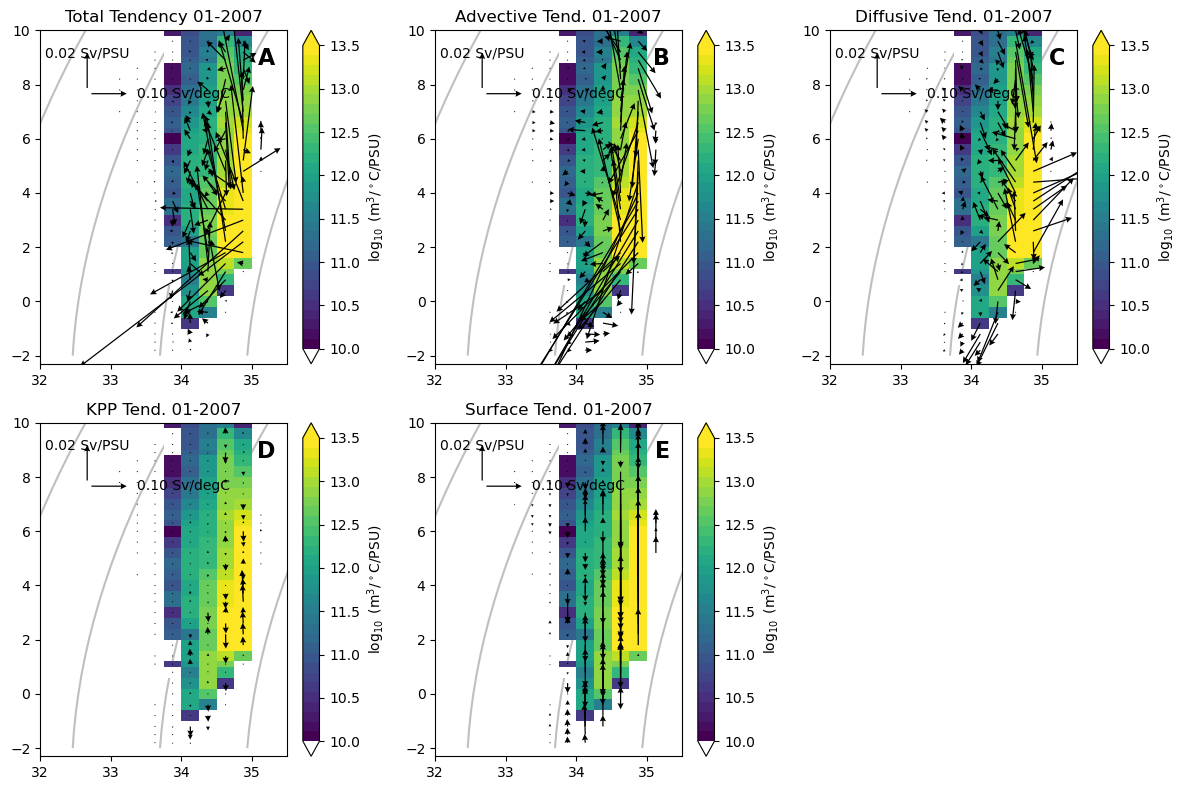

In [33]:
# define the difference in volume distribution for the two years

# Define constants
alpha, beta = 1, 0.2
arrow_length, step, t, U, scale = 0.25, 2, 0, .1, 0.7e0
ypos1, ypos2, xpos1, xpos2 = 0.81, 0.88, 0.35, 0.19

# Time string for labeling
# timestr = datetimes[0].strftime("%Y") + "-" + datetimes[-1].strftime("%Y")
timestr = datetimes[0].strftime("%m") + "-" +datetimes[0].strftime("%Y")
# timestr = "2010"

# Plot limits
xlims, ylims = np.array([32, 35.5]), np.array([-2.3, 10])

# Titles for each subplot
titles = [
    "Total Tendency", "Advective Tend.", "Diffusive Tend.",
    "KPP Tend.", "Surface Tend.", "Sum of Tendencies"
]

# Figure setup
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2x3 subplot layout
axes = axes.flatten()  # Flatten to iterate easily

for i, ax in enumerate(axes[:-1]):
    if i < 5:
        U1, V1 = JtermsS[i], JtermsT[i]  # Select tendency terms
    else:
        # Sum up all terms for the last plot
        U1, V1 = sum(JtermsS[1:5]), sum(JtermsT[1:5])

    # Apply scaling and set zero values to NaN
    U1, V1 = U1 * alpha, V1 * beta
    U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan

    # Background colormap
    cb = ax.pcolormesh(Sbin, Tbin, np.log10(np.nanmean(vol_mesh_all_2016,axis=0)), cmap=cmap2, vmin=10, vmax = 13.5,zorder=2)

    # Quiver plot
    q = ax.quiver(Sbincent, Tbincent, 
                  U1, V1, 
                  width=0.005, scale=scale, zorder=3, headwidth=5)

    # Colorbar
    plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$',extend="both")

    # Titles, limits, and labels
    ax.set_title(f"{titles[i]} {timestr}")
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    # Quiver key (for scale reference)
    ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha:.2f} Sv/degC", labelpos='E')
    ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta:.2f} Sv/PSU", angle=90, labelpos='N', coordinates='axes')

    # Label each subplot (A, B, C, etc.)
    ax.text(0.95, 0.95, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')

    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

fig.delaxes(axes[5])
# Save figure
plt.tight_layout()
# plt.savefig(path + titlestr + "full" + timestr + ".png", dpi=300)
plt.show()

In [34]:

# ---- inputs assumed to exist from your context ----
# JtermsS_nn_all_2016, JtermsS_nn_all_2007: (tsteps, 5, nS, nT)
# JtermsT_nn_all_2016, JtermsT_nn_all_2007: (tsteps, 5, nS, nT)
# Sbin, Tbin: 1D bins for pcolormesh (match nS, nT)
# si, ti, dens2: density contour grids
# path (optional): output directory string; if not set, '.' is used

xlims, ylims = np.array([32, 35.5]), np.array([-2.3, 8])
vlev = 0.5  # keep symmetric color scale centered at 0

titles = [
    "Total Convergence", "Convergence due to ADV", "Convergence due to DF",
    "Convergence due to KPP", "Convergence due to Surface"
]

# seasonal groups (0-based timestep indices)
seasons = {
    "JFM": [0, 1, 2],
    "AMJ": [3, 4, 5],
    "JAS": [6, 7, 8],
    "OND": [9,10,11],
}

outdir = locals().get("path", ".")  # use 'path' if you already defined it; else current dir

for sname, idxs in seasons.items():
    # seasonal means over time for each year
    # result shapes: (5, nS, nT)
    JtermsS_nn_2016 = np.nanmean(JtermsS_nn_all_2016[idxs, ...], axis=0)
    JtermsS_nn_2007 = np.nanmean(JtermsS_nn_all_2007[idxs, ...], axis=0)
    JtermsT_nn_2016 = np.nanmean(JtermsT_nn_all_2016[idxs, ...], axis=0)
    JtermsT_nn_2007 = np.nanmean(JtermsT_nn_all_2007[idxs, ...], axis=0)

    # figure: 2x3 grid (last panel left empty)
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:-1]):  # 5 terms -> use first 5 panels
        # --- 2016 convergence for term i ---
        U = JtermsS_nn_2016[i]  # along S bins
        V = JtermsT_nn_2016[i]  # along T bins
        div = np.gradient(U, axis=0) + np.gradient(V, axis=1)
        conv16 = -div

        # --- 2007 convergence for term i ---
        U = JtermsS_nn_2007[i]
        V = JtermsT_nn_2007[i]
        div = np.gradient(U, axis=0) + np.gradient(V, axis=1)
        conv07 = -div

        # difference (2016 - 2007)
        diff = conv16 - conv07

        # background colormap with symmetric limits centered at 0
        cb = ax.pcolormesh(Sbin, Tbin, diff, cmap="seismic",
                           vmin=-vlev, vmax=+vlev, shading="auto")
        plt.colorbar(cb, ax=ax, label="Sv  ( + means accumulation )", extend="both")

        ax.set_title(f"{titles[i]}  [{sname}]")
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.grid(True, alpha=0.3)

        # density contours
        cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5,
                        levels=np.arange(16, 32, 1))
        ax.clabel(cs, fontsize=9, inline=False, fmt="%.0f")

    # remove the unused 6th axis
    fig.delaxes(axes[-1])

    plt.tight_layout()
    outname = f"{outdir}/convergence_diff_{sname}_2x3.png"
    fig.savefig(outname, dpi=200)
    plt.close(fig)

print("Saved seasonal convergence difference figures:",
      [f"{outdir}/convergence_diff_{k}_2x3.png" for k in seasons.keys()])


Saved seasonal convergence difference figures: ['./convergence_diff_JFM_2x3.png', './convergence_diff_AMJ_2x3.png', './convergence_diff_JAS_2x3.png', './convergence_diff_OND_2x3.png']


In [35]:

# ---- inputs assumed to exist ----
# JtermsS_nn_all_2016, JtermsS_nn_all_2007: (tsteps, 5, nS, nT)
# JtermsT_nn_all_2016, JtermsT_nn_all_2007: (tsteps, 5, nS, nT)
# vol_mesh_all_2016, vol_mesh_all_2007: (tsteps, nS, nT)
# Sbin, Tbin: 1D bin centers (match nS, nT for pcolormesh)
# si, ti, dens2: density contour grids
# path (optional): output directory string
# ----------------------------------------------------

xlims, ylims = np.array([32, 35.5]), np.array([-2.3, 8])
vlev = 0.5  # symmetric color scale half-range

titles = [
    "Total Convergence", "Convergence due to ADV", "Convergence due to DF",
    "Convergence due to KPP", "Convergence due to Surface"
]

# seasonal groups (0-based timestep indices)
seasons = {
    "JFM": [0, 1, 2],
    "AMJ": [3, 4, 5],
    "JAS": [6, 7, 8],
    "OND": [9,10,11],
}

outdir = locals().get("path", ".")  # use 'path' if defined

# Choose contour levels by percentiles of volume (relative contours)
vol_percentile_levels = [50, 75, 90]  # median, upper quartiles
# If you prefer fixed fractions of max, use e.g. rel_levels = [0.2, 0.4, 0.6, 0.8]

for sname, idxs in seasons.items():
    # --- seasonal means ---
    # Flux terms (shape: (5, nS, nT))
    JS16 = np.nanmean(JtermsS_nn_all_2016[idxs, ...], axis=0)
    JT16 = np.nanmean(JtermsT_nn_all_2016[idxs, ...], axis=0)
    JS07 = np.nanmean(JtermsS_nn_all_2007[idxs, ...], axis=0)
    JT07 = np.nanmean(JtermsT_nn_all_2007[idxs, ...], axis=0)

    # Volume fields (shape: (nS, nT))
    VOL16 = np.nanmean(vol_mesh_all_2016[idxs, ...], axis=0)
    VOL07 = np.nanmean(vol_mesh_all_2007[idxs, ...], axis=0)

    # Compute percentile-based contour levels for each year (robust to scaling)
    # Mask negatives if any (volumes should be >=0)
    VOL16_pos = np.where(np.isfinite(VOL16) & (VOL16 > 0), VOL16, np.nan)
    VOL07_pos = np.where(np.isfinite(VOL07) & (VOL07 > 0), VOL07, np.nan)

    # If everything is NaN, fall back to zeros to avoid errors
    if np.all(~np.isfinite(VOL16_pos)): VOL16_pos = np.zeros_like(VOL16)
    if np.all(~np.isfinite(VOL07_pos)): VOL07_pos = np.zeros_like(VOL07)

    levels16 = np.nanpercentile(VOL16_pos, vol_percentile_levels)
    levels07 = np.nanpercentile(VOL07_pos, vol_percentile_levels)

    # --- figure ---
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:-1]):  # first 5 panels for the 5 terms
        # 2016 convergence for term i
        div16 = np.gradient(JS16[i], axis=0) + np.gradient(JT16[i], axis=1)
        conv16 = -div16

        # 2007 convergence for term i
        div07 = np.gradient(JS07[i], axis=0) + np.gradient(JT07[i], axis=1)
        conv07 = -div07

        # difference
        diff = conv16 - conv07

        # background: symmetric, centered at 0
        pcm = ax.pcolormesh(Sbin, Tbin, diff, cmap="seismic",
                            vmin=-vlev, vmax=+vlev, shading="auto")
        cb = fig.colorbar(pcm, ax=ax, shrink=0.85, extend="both")
        cb.set_label("Sv  ( + means accumulation )")

        # overlay volume contours
        # 2016: solid black
        c16 = ax.contour(Sbincent, Tbincent, VOL16, levels=[0.1],
                         colors="k", linewidths=1.0)
        # 2007: dashed grey
        c07 = ax.contour(Sbincent, Tbincent, VOL07, levels=[0.1],
                         colors="grey", linestyles="--", linewidths=1.0)

        ax.set_title(f"{titles[i]}  [{sname}]")
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.grid(True, alpha=0.3)

        # density contours
        cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5,
                        levels=np.arange(16, 32, 1))
        ax.clabel(cs, fontsize=9, inline=False, fmt="%.0f")

    # remove unused 6th axis
    fig.delaxes(axes[-1])

    # legend for volume contours (proxy artists)
    proxies = [
        Line2D([0], [0], color="k", lw=1.5, label="Volume 2016 (percentiles)"),
        Line2D([0], [0], color="grey", lw=1.5, ls="--", label="Volume 2007 (percentiles)")
    ]
    fig.legend(handles=proxies, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()
    outname = f"{outdir}/convergence_diff_{sname}_2x3.png"
    fig.savefig(outname, dpi=200, bbox_inches="tight")
    plt.close(fig)

print("Saved seasonal convergence difference figures with volume contours:",
      [f"{outdir}/convergence_diff_{k}_2x3.png" for k in seasons.keys()])


Saved seasonal convergence difference figures with volume contours: ['./convergence_diff_JFM_2x3.png', './convergence_diff_AMJ_2x3.png', './convergence_diff_JAS_2x3.png', './convergence_diff_OND_2x3.png']


In [36]:
JS16.shape

(5, 112, 112)

In [37]:
# set index of interest -- surface = 4
i = 4

# ---- inputs assumed to exist ----
# JtermsS_nn_all_2016, JtermsS_nn_all_2007: (tsteps, 5, nS, nT)
# JtermsT_nn_all_2016, JtermsT_nn_all_2007: (tsteps, 5, nS, nT)
# vol_mesh_all_2016, vol_mesh_all_2007: (tsteps, nS, nT)
# Sbin, Tbin: 1D bin centers (match nS, nT for pcolormesh)
# si, ti, dens2: density contour grids
# path (optional): output directory string
# ----------------------------------------------------

xlims, ylims = np.array([32, 35.5]), np.array([-2.3, 12])
vlev = 0.5  # symmetric color scale half-range

titles = [
    "Total Convergence", "Convergence due to ADV", "Convergence due to DF",
    "Convergence due to KPP", "Convergence due to Surface"
]

# seasonal groups (0-based timestep indices)
seasons = {
    "JFM": [0, 1, 2],
    "AMJ": [3, 4, 5],
    "JAS": [6, 7, 8],
    "OND": [9,10,11],
}

outdir = locals().get("path", ".")  # use 'path' if defined

# Choose contour levels by percentiles of volume (relative contours)
vol_percentile_levels = [50, 75, 90]  # median, upper quartiles
# If you prefer fixed fractions of max, use e.g. rel_levels = [0.2, 0.4, 0.6, 0.8]

for sname, idxs in seasons.items():
    # --- seasonal means ---
    # Flux terms (shape: (5, nS, nT))
    JS16 = np.nanmean(JtermsS_nn_all_2016[idxs, ...], axis=0)
    JT16 = np.nanmean(JtermsT_nn_all_2016[idxs, ...], axis=0)
    JS07 = np.nanmean(JtermsS_nn_all_2007[idxs, ...], axis=0)
    JT07 = np.nanmean(JtermsT_nn_all_2007[idxs, ...], axis=0)

    # Volume fields (shape: (nS, nT))
    VOL16 = np.nanmean(vol_mesh_all_2016[idxs, ...], axis=0)
    VOL07 = np.nanmean(vol_mesh_all_2007[idxs, ...], axis=0)

    # --- figure ---
    fig = plt.figure(figsize=(12, 4))

    # 2007 convergence for term i
    div07 = np.gradient(JS07[i], axis=0) + np.gradient(JT07[i], axis=1)
    conv07 = -div07
    ax = plt.subplot(131)
    pcm = ax.pcolormesh(Sbin, Tbin, conv07, cmap="seismic", vmin=-vlev, vmax=+vlev, shading="auto")
    cb = fig.colorbar(pcm, ax=ax, shrink=0.85, extend="both")
    cb.set_label("Sv  ( + means accumulation )")
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_title("2007 Surface conv")

    
    # first subplot -- surface convergence for 2007
    div16 = np.gradient(JS16[i], axis=0) + np.gradient(JT16[i], axis=1)
    conv16 = -div16
    ax = plt.subplot(132)
    pcm = ax.pcolormesh(Sbin, Tbin, conv16, cmap="seismic", vmin=-vlev, vmax=+vlev, shading="auto")
    cb = fig.colorbar(pcm, ax=ax, shrink=0.85, extend="both")
    cb.set_label("Sv  ( + means accumulation )")
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_title("2016 Surface conv")


    # last subplot - difference with the contours of the volume
    ax = plt.subplot(133)
    # difference
    diff = conv16 - conv07
    # background: symmetric, centered at 0
    pcm = ax.pcolormesh(Sbin, Tbin, diff, cmap="seismic",
                        vmin=-vlev, vmax=+vlev, shading="auto")
    cb = fig.colorbar(pcm, ax=ax, shrink=0.85, extend="both")
    cb.set_label("Sv  ( + means accumulation )")

    # overlay volume contours
    # 2016: solid black
    c16 = ax.contour(Sbincent, Tbincent, VOL16, levels=[0.01],
                     colors="k", linewidths=1.0)
    # 2007: dashed grey
    c07 = ax.contour(Sbincent, Tbincent, VOL07, levels=[0.01],
                     colors="grey", linestyles="--", linewidths=1.0)

    ax.set_title(f"{titles[i]}  [{sname}]")
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.grid(True, alpha=0.3)

    # density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5,
                    levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=9, inline=False, fmt="%.0f")


    # legend for volume contours (proxy artists)
    proxies = [
        Line2D([0], [0], color="k", lw=1.5, label="Volume 2016"),
        Line2D([0], [0], color="grey", lw=1.5, ls="--", label="Volume 2007")
    ]
    fig.legend(handles=proxies, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()
    outname = f"{outdir}/convergence_diff_{sname}_2x3.png"
    fig.savefig(outname, dpi=200, bbox_inches="tight")
    plt.close(fig)

print("Saved seasonal convergence difference figures with volume contours:",
      [f"{outdir}/convergence_diff_{k}_2x3.png" for k in seasons.keys()])


Saved seasonal convergence difference figures with volume contours: ['./convergence_diff_JFM_2x3.png', './convergence_diff_AMJ_2x3.png', './convergence_diff_JAS_2x3.png', './convergence_diff_OND_2x3.png']


# in map view try to understand the differences between these two regions

What are the signs that this was transitioning from a marginal ice zone to completely ice free? Fully Atlantified?

Surface: warming and salting at the surface in 2016

ADV: formation of BSW

In [38]:
# what are the surface terms contributing to salting and warming?
# plot the differences between SFLUX, oceSPflx, oceSflux, WSLTMASS
tsstr

array(['0000262944', '0000267408', '0000271440', '0000275904',
       '0000280224', '0000284688', '0000289008', '0000293472',
       '0000297936', '0000302256', '0000306720', '0000311040',
       '0000315504'], dtype='<U32')

In [39]:
# plot the differences between surface temperature: TFLUX oceQsw SItflux oceQnet WTHMASS

def get_recs(dirIn, file_name, ts0, varnames):
    meta = parsemeta(f"{dirIn}{file_name}.{ts0}.meta")
    fldlist = np.array(meta["fldList"]).astype(str)   # robust if bytes
    return [int(np.where(fldlist == v)[0][0]) for v in varnames]

def read_fields(dirIn, file_name, t2, recs, nx, ny):
    outs = []
    for r in recs:
        fld, its, meta = rdmds(os.path.join(dirIn, file_name), t2, returnmeta=True, rec=int(r))
        outs.append(fld.reshape(ny, nx))
    return outs

def collect_year_with_tsstr(dirIn, tsstr, nx, ny):
    nt = len(tsstr)

    set1_name, set1_vars = "budg2d_zflux_set1", ["TFLUX","oceQsw","SItflux"]
    set2_name, set2_vars = "budg2d_zflux_set2", ["oceQnet","WTHMASS","SIaaflux","TRELAX"]

    set1_recs = get_recs(dirIn, set1_name, tsstr[0], set1_vars)
    set2_recs = get_recs(dirIn, set2_name, tsstr[0], set2_vars)

    out = {
        "TFLUX":   np.empty((nt, ny, nx)),
        "oceQsw":  np.empty((nt, ny, nx)),
        "SItflux": np.empty((nt, ny, nx)),
        "oceQnet": np.empty((nt, ny, nx)),
        "WTHMASS": np.empty((nt, ny, nx)),
        "SIaaflux":np.empty((nt, ny, nx)),
        "TRELAX":  np.empty((nt, ny, nx)),
    }

    for i in range(nt):
        t2 = int(tsstr[i])  # <-- per your note

        TFLUX, oceQsw, SItflux = read_fields(dirIn, set1_name, t2, set1_recs, nx, ny)
        out["TFLUX"][i]    = TFLUX
        out["oceQsw"][i]   = oceQsw
        out["SItflux"][i]  = SItflux

        oceQnet, WTHMASS, SIaaflux, TRELAX = read_fields(dirIn, set2_name, t2, set2_recs, nx, ny)
        out["oceQnet"][i]  = oceQnet
        out["WTHMASS"][i]  = WTHMASS
        out["SIaaflux"][i] = SIaaflux
        out["TRELAX"][i]   = TRELAX

    return out

# ----- run for 2007 + 2016 -----
data_2007 = collect_year_with_tsstr(dirIn, tsstr,  nx, ny)   # t2 = int(tsstr[i])
data_2016 = collect_year_with_tsstr(dirIn, tsstr2, nx, ny)   # t2 = int(tsstr2[i])

np.savez("zflux_2007.npz", **data_2007)
np.savez("zflux_2016.npz", **data_2016)

# ----- load later -----
d07 = np.load("zflux_2007.npz")
d16 = np.load("zflux_2016.npz")
# e.g., TFLUX_2016 = d16["TFLUX"]


In [40]:
# load data
d07 = np.load("zflux_2007.npz")
d16 = np.load("zflux_2016.npz")

# TFLUX + increase T
# oceQsw + increase T

vars_to_plot = ["TFLUX", "oceQsw", "SItflux", "oceQnet", "SIaaflux"]

# seasonal groups (1-based month indices -> zero-based array indices)
seasons = {
    "JFM":  [0, 1, 2],        # 1,2,3
    "AMJ":  [3, 4, 5],        # 4,5,6
    "JAS":  [6, 7, 8],        # 7,8,9
    "OND":  [9,10,11],        # 10,11,12
}

def mean_over_indices(arr, idxs):
    """Mean over selected time indices along axis=0, ignoring NaNs."""
    return np.nanmean(arr[idxs, ...], axis=0)

for sname, idxs in seasons.items():
    fig, axes = plt.subplots(2, 3, figsize=(13, 9), constrained_layout=True)
    axes = axes.ravel()

    for j, v in enumerate(vars_to_plot):
        fld07 = d07[v]  # shape (nt, ny, nx)
        fld16 = d16[v]  # shape (nt, ny, nx)

        # seasonal mean difference
        diff = mean_over_indices(fld16, idxs) - mean_over_indices(fld07, idxs)

        # transform and mask
        tracer = get_aste_tracer(diff * mymsk, nfx, nfy)[0]

        ax = axes[j]

        # symmetric color scale centered at 0
        vmax = np.nanmax(np.abs(tracer))
        if not np.isfinite(vmax) or vmax == 0:
            vmax = 1.0  # fallback to avoid invalid vlims
        vmin = -vmax

        pcm = ax.pcolormesh(tracer, cmap="seismic", vmin=vmin, vmax=vmax)
        ax.set_xlim(400, 540)
        ax.set_ylim(400, 600)

        # overlay land (assumes land_data aligned with tracer grid)
        ax.pcolormesh(land_data, cmap="Greys", zorder=7, vmin=0, vmax=6)

        ax.set_title(v)
        cbar = fig.colorbar(pcm, ax=ax, shrink=0.85)
        cbar.set_label(f"{v} (2016 – 2007) [{sname}]")

    # hide any unused axes (not needed here since we have exactly 6 vars)
    # for k in range(len(vars_to_plot), 6):
    #     fig.delaxes(axes[k])

    fig.suptitle(f"Seasonal Differences (2016 – 2007): {sname}", fontsize=14)
    outname = f"diff_{sname}_2x3.png"
    fig.savefig(outname, dpi=200)
    plt.close(fig)

print("Saved seasonal figures:", [f"diff_{s}_{'2x3'}.png" for s in seasons.keys()])


Saved seasonal figures: ['diff_JFM_2x3.png', 'diff_AMJ_2x3.png', 'diff_JAS_2x3.png', 'diff_OND_2x3.png']


In [41]:
# do the same for the surface salt fluxes

import os
import numpy as np

def get_recs(dirIn, file_name, ts0, varnames):
    """Return a dict var->rec_index or None if not found."""
    meta = parsemeta(f"{dirIn}{file_name}.{ts0}.meta")
    fldlist = np.array(meta["fldList"]).astype(str)
    recs = {}
    for v in varnames:
        idx = np.where(fldlist == v)[0]
        recs[v] = int(idx[0]) if idx.size > 0 else None
    return recs

def read_one(dirIn, file_name, t2, rec, nx, ny):
    """Read one record and reshape to (ny,nx). If rec is None, return NaNs."""
    if rec is None:
        return np.full((ny, nx), np.nan, dtype=float)
    fld, its, meta = rdmds(os.path.join(dirIn, file_name), t2, returnmeta=True, rec=int(rec))
    return fld.reshape(ny, nx)

def collect_year_sflux(dirIn, tsstr, nx, ny):
    """
    For a given list of timestep strings, read salt-related fluxes:
      set1: oceSPflx, SFLUX
      set2: oceSflux, WSLTMASS, SRELAX
    Return dict of arrays stacked as (nt, ny, nx). Missing vars -> NaNs.
    """
    nt = len(tsstr)

    set1_name, set1_vars = "budg2d_zflux_set1", ["oceSPflx", "SFLUX"]
    set2_name, set2_vars = "budg2d_zflux_set2", ["oceSflux", "WSLTMASS", "SRELAX"]

    # parse record indices once using the first timestep
    set1_recs = get_recs(dirIn, set1_name, tsstr[0], set1_vars)
    set2_recs = get_recs(dirIn, set2_name, tsstr[0], set2_vars)

    # preallocate
    out = {v: np.empty((nt, ny, nx), dtype=float) for v in (set1_vars + set2_vars)}

    # loop over timesteps
    for i, ts in enumerate(tsstr):
        t2 = int(ts)

        # set1
        out["oceSPflx"][i] = read_one(dirIn, set1_name, t2, set1_recs["oceSPflx"], nx, ny)
        out["SFLUX"][i]    = read_one(dirIn, set1_name, t2, set1_recs["SFLUX"],    nx, ny)

        # set2
        out["oceSflux"][i] = read_one(dirIn, set2_name, t2, set2_recs["oceSflux"], nx, ny)
        out["WSLTMASS"][i] = read_one(dirIn, set2_name, t2, set2_recs["WSLTMASS"], nx, ny)
        out["SRELAX"][i]   = read_one(dirIn, set2_name, t2, set2_recs["SRELAX"],   nx, ny)

    return out

# ----- run for 2007 + 2016 -----
salt_2007 = collect_year_sflux(dirIn, tsstr,  nx, ny)   # uses t2 = int(tsstr[i])
salt_2016 = collect_year_sflux(dirIn, tsstr2, nx, ny)   # uses t2 = int(tsstr2[i])

np.savez("sflux_2007.npz", **salt_2007)
np.savez("sflux_2016.npz", **salt_2016)

# ----- load later -----
s07 = np.load("sflux_2007.npz")   # keys: oceSPflx, SFLUX, oceSflux, WSLTMASS, SRELAX
s16 = np.load("sflux_2016.npz")


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# load salt flux data
s07 = np.load("sflux_2007.npz")
s16 = np.load("sflux_2016.npz")

vars_to_plot = ["oceSPflx", "SFLUX", "oceSflux"]

# seasonal groups (1-based months -> zero-based indices)
seasons = {
    "JFM":  [0, 1, 2],
    "AMJ":  [3, 4, 5],
    "JAS":  [6, 7, 8],
    "OND":  [9,10,11],
}

def mean_over_indices(arr, idxs):
    return np.nanmean(arr[idxs, ...], axis=0)

for sname, idxs in seasons.items():
    fig, axes = plt.subplots(2, 3, figsize=(13, 9), constrained_layout=True)
    axes = axes.ravel()

    for j, v in enumerate(vars_to_plot):
        fld07 = s07[v]
        fld16 = s16[v]

        # seasonal mean difference
        diff = mean_over_indices(fld16, idxs) - mean_over_indices(fld07, idxs)

        # transform and mask
        tracer = get_aste_tracer(diff * mymsk, nfx, nfy)[0]

        ax = axes[j]

        # symmetric color scale
        vmax = np.nanmax(np.abs(tracer))
        vmax = vmax if np.isfinite(vmax) and vmax > 0 else 1.0
        vmin = -vmax

        pcm = ax.pcolormesh(tracer, cmap="seismic", vmin=vmin, vmax=vmax)
        ax.set_xlim(400, 540)
        ax.set_ylim(400, 600)

        # overlay land
        ax.pcolormesh(land_data, cmap="Greys", zorder=7, vmin=0, vmax=6)

        ax.set_title(v)
        cbar = fig.colorbar(pcm, ax=ax, shrink=0.85)
        cbar.set_label(f"{v} (2016 – 2007) [{sname}]")

    # remove unused panels (right 3 in 2×3 grid)
    for k in range(len(vars_to_plot), 6):
        fig.delaxes(axes[k])

    fig.suptitle(f"Salt Flux Differences (2016 – 2007): {sname}", fontsize=14)
    outname = f"sflux_diff_{sname}_2x3.png"
    fig.savefig(outname, dpi=200)
    plt.close(fig)

print("Saved seasonal salt flux figures:", [f"sflux_diff_{s}_2x3.png" for s in seasons.keys()])


Saved seasonal salt flux figures: ['sflux_diff_JFM_2x3.png', 'sflux_diff_AMJ_2x3.png', 'sflux_diff_JAS_2x3.png', 'sflux_diff_OND_2x3.png']


## if we're seeing a contraction of BSW in general/formation of warmer waters, why?
- in general, what is the difference in TS distribution for the sets of seasons? (2x2)
- how is the surface term different within this region?
- how much of this is due to the inflow (this is at the entrance to the BS

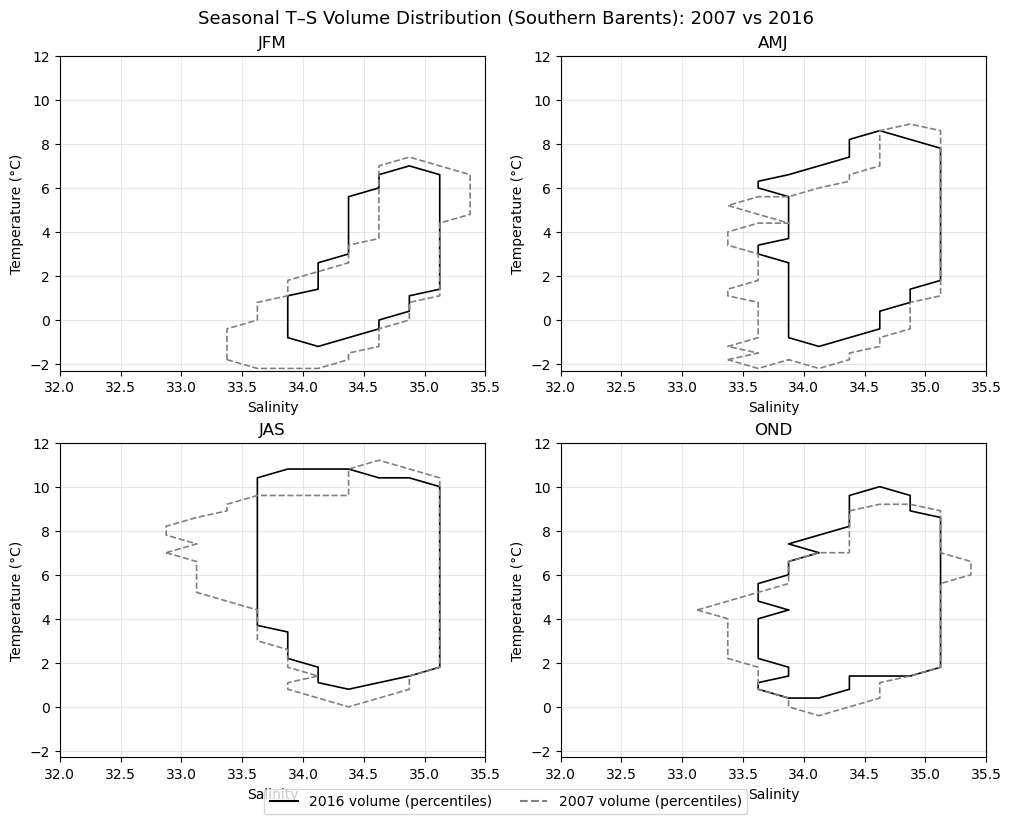

In [43]:
# ---- Assumed available ----
# vol_mesh_all_2016, vol_mesh_all_2007 : (tsteps, nS, nT)
# Sbin, Tbin : 1D edges or centers for S and T
# xlims, ylims : np.array([Smin, Smax]), np.array([Tmin, Tmax])
# ----------------------------------------------------

seasons = {"JFM":[0,1,2], "AMJ":[3,4,5], "JAS":[6,7,8], "OND":[9,10,11]}
xlims, ylims = np.array([32, 35.5]), np.array([-2.3, 12])

def centers(a, target_len):
    a = np.asarray(a)
    if a.size == target_len + 1:  # edges -> centers
        return 0.5*(a[:-1] + a[1:])
    elif a.size == target_len:    # already centers
        return a
    else:
        raise ValueError(f"Incompatible axis length {a.size} for target {target_len}.")

# choose contour levels via percentiles (robust to scale differences)
vol_percentile_levels = [50, 75, 90]  # median, upper quartiles

# seasonal means of volume
VOL16_seas = {}
VOL07_seas = {}
for sname, idxs in seasons.items():
    VOL16_seas[sname] = np.nanmean(vol_mesh_all_2016[idxs, ...], axis=0)  # (nS, nT)
    VOL07_seas[sname] = np.nanmean(vol_mesh_all_2007[idxs, ...], axis=0)

# Bin centers (once; use any season to get shape)
nS, nT = next(iter(VOL16_seas.values())).shape

# Build the figure (2x2: JFM, AMJ, JAS, OND)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
axes = axes.ravel()
order = ["JFM", "AMJ", "JAS", "OND"]

for ax, sname in zip(axes, order):
    VOL16 = VOL16_seas[sname]
    VOL07 = VOL07_seas[sname]

    # 2016 (solid black) and 2007 (dashed grey) contours
    ax.contour(Sbincent, Tbincent, VOL16, levels=[0.01], colors="k", linewidths=1.2)
    ax.contour(Sbincent, Tbincent, VOL07, levels=[0.01], colors="grey", linestyles="--", linewidths=1.2)

    ax.set_title(sname)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Salinity")
    ax.set_ylabel("Temperature (°C)")

# Legend (shared)
proxies = [
    Line2D([0],[0], color="k", lw=1.5, label="2016 volume (percentiles)"),
    Line2D([0],[0], color="grey", lw=1.5, ls="--", label="2007 volume (percentiles)")
]
fig.legend(handles=proxies, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.02))

fig.suptitle("Seasonal T–S Volume Distribution (Southern Barents): 2007 vs 2016", fontsize=13)
plt.show()
# To save: fig.savefig("ts_volume_contours_2x2.png", dpi=200, bbox_inches="tight")

In [76]:
# load the gateway transports and plot as TS diagram
# load the gateway transports for 2007
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_2007.npy", allow_pickle=True).item()

heat_transport_timeseries07 = loaded_data["heat_transport_timeseries"]
salt_transport_timeseries07 = loaded_data["salt_transport_timeseries"]
theta_timeseries07 = loaded_data["theta_timeseries"]
salt_timeseries07 = loaded_data["salt_timeseries"]
binned_theta_timeseries07 = loaded_data["binned_theta_timeseries"]
binned_salt_timeseries07 = loaded_data["binned_salt_timeseries"]

# load the gateway transports for 2016
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_2016.npy", allow_pickle=True).item()

heat_transport_timeseries16 = loaded_data["heat_transport_timeseries"]
salt_transport_timeseries16 = loaded_data["salt_transport_timeseries"]
theta_timeseries16 = loaded_data["theta_timeseries"]
salt_timeseries16 = loaded_data["salt_timeseries"]
binned_theta_timeseries16 = loaded_data["binned_theta_timeseries"]
binned_salt_timeseries16 = loaded_data["binned_salt_timeseries"]

In [45]:
def compute_gradient_manual(data_s, data_t, spacing_s, spacing_t):
    # Gradient for salinity along axis 0
    gradient_s = np.zeros_like(data_s)
    gradient_s[1:-1] = (data_s[2:] - data_s[:-2]) / (spacing_s[2:] + spacing_s[:-2])
    gradient_s[0] = (data_s[1] - data_s[0]) / spacing_s[1]  # forward difference at start
    gradient_s[-1] = (data_s[-1] - data_s[-2]) / spacing_s[-1]  # backward difference at end

    # Gradient for temperature along axis 1
    gradient_t = np.zeros_like(data_t)
    gradient_t[:, 1:-1] = (data_t[:, 2:] - data_t[:, :-2]) / (spacing_t[:, 2:] + spacing_t[:, :-2])
    gradient_t[:, 0] = (data_t[:, 1] - data_t[:, 0]) / spacing_t[:, 1]  # forward difference at start
    gradient_t[:, -1] = (data_t[:, -1] - data_t[:, -2]) / spacing_t[:, -1]  # backward difference at end

    return gradient_s, gradient_t

In [46]:
# compute the gate transports

# now to try and show that this gate convergence fits with previous solution
def m_TS_from_prebinned(heat_tr, salt_tr, iT, iS, Tcent, Scent, binwidthT, binwidthS,
                        T_min=1e-3, S_min=1e-4):
    """
    Inputs:
      heat_tr : (nz, nfaces)  degC·m^3/s  (T*Q)
      salt_tr : (nz, nfaces)  psu·m^3/s   (S*Q)
      iT, iS  : (nz, nfaces)  integer bin indices in [0..nT-1],[0..nS-1]
      Tcent   : (nT,)         bin centers (degC)
      Scent   : (nS,)         bin centers (psu)
    Output:
      m_TS    : (nS, nT)      Sv/(psu·°C)
    """
    nT = len(Tcent); nS = len(Scent)
    m_TS = np.zeros((nS-1, nT-1), dtype=float)

    # Flatten
    HT  = heat_tr.reshape(-1)              # degC·m^3/s
    ST  = salt_tr.reshape(-1)              # psu·m^3/s
    iTf = iT.reshape(-1).astype(int)
    iSf = iS.reshape(-1).astype(int)

    # Valid bins
    valid = (iTf >= 0) & (iTf < nT) & (iSf >= 0) & (iSf < nS)
    if not np.any(valid):
        return m_TS

    iTv = iTf[valid]; iSv = iSf[valid]
    HTv = HT[valid];  STv = ST[valid]

    # Get bin-center T,S for those indices
    Tv = Tcent[iTv]; Sv = Scent[iSv]

    # Recover Q (m^3/s). Prefer salt (often better conditioned), fallback to heat.
    Qs = np.where(np.abs(Sv) > S_min, STv / Sv, np.nan)
    Qt = np.where(np.abs(Tv) > T_min, HTv / Tv, np.nan)
    Q  = np.where(np.isfinite(Qs), Qs, Qt)
    Q  = np.where(np.isfinite(Q), Q, 0.0)   # m^3/s (+ into basin)

    # Convert to Sv and normalize by ΔS·ΔT → Sv/(psu·°C)
    dSv = binwidthS[iSv]; dTv = binwidthT[iTv]
    contrib = (Q * 1e-6) / (dSv * dTv)

    np.add.at(m_TS, (iSv, iTv), contrib)
    return m_TS


# Bin metadata
binsT_edges = binsTH_edges            # len = nT+1
binsS_edges = binsSLT_edges           # len = nS+1
binwidthT   = binsT_edges[1:] - binsT_edges[:-1]   # (nT,)
binwidthS   = binsS_edges[1:] - binsS_edges[:-1]   # (nS,)
Tcent       = 0.5 * (binsT_edges[1:] + binsT_edges[:-1])  # (nT,)
Scent       = 0.5 * (binsS_edges[1:] + binsS_edges[:-1])  # (nS,)

In [47]:

def m_TS_total_from_timeseries(
    heat_ts_by_gate,          # dict: gate -> array [nyears, 12, nz, nfaces]
    salt_ts_by_gate,          # dict: gate -> array [nyears, 12, nz, nfaces]
    iT_ts_by_gate,            # dict: gate -> array [nyears, 12, nz, nfaces] (ints)
    iS_ts_by_gate,            # dict: gate -> array [nyears, 12, nz, nfaces] (ints)
    Tcent, Scent,             # bin centers
    binwidthT, binwidthS,     # bin widths
    year_idx,
    months=None,              # list of month indices to average (e.g., [0,1,2]); if None, uses all 12
    gates=("BSO","SFJ","FJNZ","NZRU"),
    reducer="mean"            # "mean" or "sum" across selected months
):
    """
    Build m_TS_total (Sv/(psu·°C)) by:
      1) computing m_TS_from_prebinned per month per gate,
      2) averaging (or summing) across the selected months per gate,
      3) summing across gates.

    Parameters
    ----------
    heat_ts_by_gate, salt_ts_by_gate, iT_ts_by_gate, iS_ts_by_gate : dict[str, np.ndarray]
        Each maps gate -> array shaped [nyear, 12, nz, nfaces] (int types for iT/iS).
    Tcent, Scent : 1D arrays
        Bin centers for T and S.
    binwidthT, binwidthS : 1D arrays
        Bin widths for T and S. Assumes `m_TS_from_prebinned` expects these.
    year_idx : int
        Index into the 'year' dimension of the timeseries arrays.
    months : list[int] | None
        0-based month indices to average. If None, uses range(12).
    gates : iterable[str]
        Gates to include.
    reducer : {"mean", "sum"}
        How to combine over months (default "mean").

    Returns
    -------
    m_TS_total : 2D np.ndarray
        Seasonal-aggregated m_TS summed over the provided gates, units Sv/(psu·°C).
    """
    if months is None:
        months = list(range(12))
    # sanity-check month indices
    months = [int(m) for m in months]
    if any((m < 0 or m > 11) for m in months):
        raise ValueError(f"Month indices must be in [0,11]; got {months}")

    # Helper to combine across months
    def _combine(stack, reducer):
        if reducer == "mean":
            return np.nanmean(stack, axis=0)
        elif reducer == "sum":
            return np.nansum(stack, axis=0)
        else:
            raise ValueError(f"Unknown reducer: {reducer}")

    m_by_gate = {}

    for g in gates:
        m_list = []
        for m in months:
            HT = heat_ts_by_gate[g][year_idx, m]  # (nz, nfaces)
            ST = salt_ts_by_gate[g][year_idx, m]  # (nz, nfaces)
            iT = iT_ts_by_gate[g][year_idx, m]    # (nz, nfaces) ints
            iS = iS_ts_by_gate[g][year_idx, m]    # (nz, nfaces) ints

            # User-provided function: returns m_TS on (S,T) bins, units Sv/(psu·°C)
            m_gate_month = m_TS_from_prebinned(HT, ST, iT, iS, Tcent, Scent, binwidthT, binwidthS)
            m_list.append(m_gate_month)

        # average (or sum) across selected months for this gate
        m_by_gate[g] = _combine(np.stack(m_list, axis=0), reducer)

    # sum over gates to get the total
    m_TS_total = np.sum([m_by_gate[g] for g in gates], axis=0)
    return m_TS_total


months_all = list(range(12))

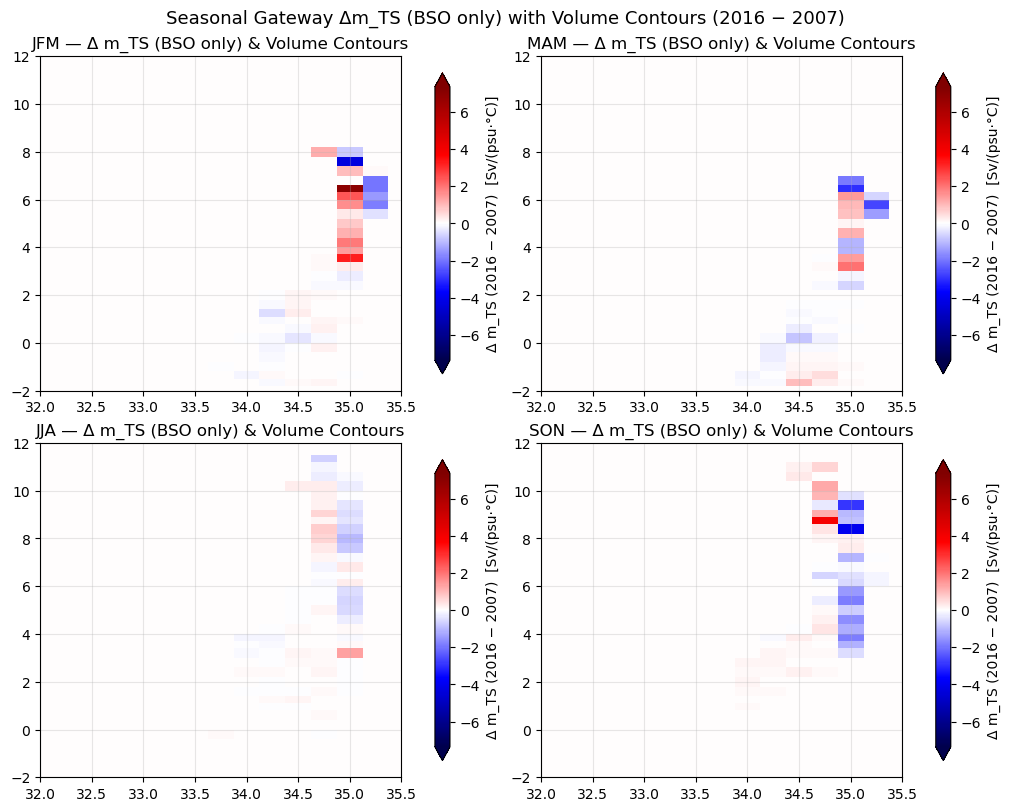

In [48]:
# -------- assumed available in your session --------
# heat_transport_timeseries07, salt_transport_timeseries07,
# binned_theta_timeseries07, binned_salt_timeseries07
# heat_transport_timeseries16, salt_transport_timeseries16,
# binned_theta_timeseries16, binned_salt_timeseries16
# vol_mesh_all_2007, vol_mesh_all_2016      # shape: (tsteps, nS, nT)
# Tcent, Scent, binwidthT, binwidthS
# Sbin2, Tbin2
# Sbincent, Tbincent  # centers for contouring (if not present, set to Scent/Tcent)
# m_TS_total_from_timeseries(...) as defined above
# ---------------------------------------------------

# Seasons (0-based month indices)
seasons = {
    "JFM": np.array([0, 1, 2]),
    "MAM": np.array([2, 3, 4]),
    "JJA": np.array([6, 7, 8]),
    "SON": np.array([9,10,11]),
}
order = ["JFM", "MAM", "JJA", "SON"]

def centers_to_edges(a):
    a = np.asarray(a)
    mid = 0.5 * (a[:-1] + a[1:])
    first = a[0] - (a[1] - a[0]) / 2.0
    last  = a[-1] + (a[-1] - a[-2]) / 2.0
    return np.concatenate(([first], mid, [last]))

# pcolormesh grids (edges preferred, but we’ll plot on centers to match your call)
if 'Sbin2' in globals() and 'Tbin2' in globals():
    Splot = Sbin2
    Tplot = Tbin2
else:
    Splot = centers_to_edges(Scent)
    Tplot = centers_to_edges(Tcent)

# contour grids (centers preferred)
if 'Sbincent' not in globals():
    Sbincent = Scent
if 'Tbincent' not in globals():
    Tbincent = Tcent

def m_ts_year_season(year, months):
    if year == 2007:
        return m_TS_total_from_timeseries(
            heat_transport_timeseries07, salt_transport_timeseries07,
            binned_theta_timeseries07, binned_salt_timeseries07,
            Tcent, Scent, binwidthT, binwidthS,
            year_idx=0, months=months,
            gates=("BSO",),                    # <-- ONLY BSO
            reducer="mean"
        )
    elif year == 2016:
        return m_TS_total_from_timeseries(
            heat_transport_timeseries16, salt_transport_timeseries16,
            binned_theta_timeseries16, binned_salt_timeseries16,
            Tcent, Scent, binwidthT, binwidthS,
            year_idx=0, months=months,
            gates=("BSO",),                    # <-- ONLY BSO
            reducer="mean"
        )
    else:
        raise ValueError("year must be 2007 or 2016")

# Compute per-season Δm_TS (2016 - 2007) and seasonal volume means
diffs = {}
mts16_all = {}
mts07_all = {}
VOL16_seas, VOL07_seas = {}, {}
for s in order:
    idxs = seasons[s]
    mts07 = m_ts_year_season(2007, idxs)
    mts16 = m_ts_year_season(2016, idxs)
    diffs[s] = mts16 - mts07  # Sv/(psu·°C)
    mts16_all[s] = mts16
    mts07_all[s] = mts07

    VOL16_seas[s] = np.nanmean(vol_mesh_all_2016[idxs, ...], axis=0)  # (nS, nT)
    VOL07_seas[s] = np.nanmean(vol_mesh_all_2007[idxs, ...], axis=0)

# Shared symmetric color scale across seasons
vmax = max(np.nanmax(np.abs(Z)) for Z in diffs.values())
vlev = (1.05 * vmax) if np.isfinite(vmax) and vmax > 0 else 1.0

# 2×2 plot of seasonal differences with volume contours
fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
axes = axes.ravel()

# percentile levels for contours (robust to magnitude differences)
vol_percentiles = [50, 75, 90]

for ax, s in zip(axes, order):
    Z = diffs[s]
    # If your m_TS_from_prebinned returns (T,S), keep as-is; if (S,T), use Z.T
    pcm = ax.pcolormesh(Sbincent, Tbincent, Z, cmap="seismic",
                        vmin=-vlev, vmax=+vlev, shading="auto")
    plt.colorbar(pcm, ax=ax, shrink=0.9, extend="both",
                 label="Δ m_TS (2016 − 2007)  [Sv/(psu·°C)]")

    # seasonal volumes
    V16 = mts16_all[s]
    V07 = mts07_all[s]

    # overlay volume contours (transpose so Z is (len(T), len(S)))
    # ax.contour(Sbincent[:-1,:-1], Tbincent[:-1,:-1], V16, levels=[1e-12], colors="k", linewidths=1.0)
    # ax.contour(Sbincent[:-1,:-1], Tbincent[:-1,:-1], V07, levels=[1e-12], colors="grey", linestyles="--", linewidths=1.0)

    ax.set_xlim(32, 35.5)
    ax.set_ylim(-2, 12)
    ax.set_title(f"{s} — Δ m_TS (BSO only) & Volume Contours")
    ax.grid(alpha=0.3)

# # shared legend for volume contours
# proxies = [
#     Line2D([0],[0], color="k", lw=1.5, label="2016 volume (percentiles)"),
#     Line2D([0],[0], color="grey", lw=1.5, ls="--", label="2007 volume (percentiles)")
# ]
# fig.legend(handles=proxies, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.03))

fig.suptitle("Seasonal Gateway Δm_TS (BSO only) with Volume Contours (2016 − 2007)", fontsize=13)
plt.savefig("gateway_mTS_diff_BSO_only_2x2.png", dpi=300, bbox_inches="tight")
plt.show()


In [49]:
# how do we compare the temperature of the inflow itself? can look at the gate transects compared for the two years

In [50]:
# let's do a 2x2 which is the difference in BSO T and BSO S and also the avg profile differences in T and S for this region

# do this by looping through the salt and heat -- we want to make an average of these as depth
# ArcWater = np.zeros((ntimes,nz,ny,nx))   # file to store True/False Arctic Water exists as a mask
# save the average T and S profiles with depth
ntimes = 12*2
thetaprofile = np.zeros((nz,ntimes))
saltprofile = np.zeros((nz,ntimes))
ArcWater = np.zeros((nz,ntimes))
alldatetimes = np.array([])

# do indexing in years for the layers
iy = 0
allyears = np.array([2007,2016])
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR = np.reshape(SALTDRi,(nz,ny,nx))

        thisTHETA = THETADR/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # degC
        thisTHETA[thisTHETA == 0] = np.nan   # this was messing up averaging without this precaution

        # do the depth averaging for freshwater
        thisSALT = SALTDR/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # PSU
        thisSALT[thisSALT == 0] = np.nan

        thetaprofile[:,iy] = np.nanmean(thisTHETA,axis=(1,2))
        saltprofile[:,iy] = np.nanmean(thisSALT,axis=(1,2))
        
        #avgTHETA[iy,i,:,:,:] = thisTHETA
        #avgSALT[iy,i,:,:,:] = thisSALT
        
        # get the indices where there is Arctic Water
        ArcW_mask = (thisTHETA < 0) & (thisSALT >= 34) & (thisSALT <= 34.7)
        #AW_mask = (thisTHETA > 2) & (thisSALT >= 34.5)


        ##########################################################################################
        # following will be to calculate the thickness of the Arctic Water
        # create a mask for Arctic Water
        # Create mask where theta < 0 and 34 <= salt <= 34.7

        # get the average thickness of the Arctic Water as a mask of the basin
        
        # this will need to use DRF3d
        ArcW = np.zeros_like(DRF3d)
        
        # Assign values from DRF3d where the mask is True
        ArcW[ArcW_mask] = DRF3d[ArcW_mask]   # of shape nz,ny,nx
        ArcW[ArcW > 0] = 1
        ArcW[ArcW == 0] = 0
        
        # try to take a mean of these in axes 1 and 2 -- not sure if this is the correct way
        #print(np.mean(ArcW, axis = (1,2)))
        ArcWater[:,iy] = np.mean(ArcW, axis = (1,2))
        
        # If you just want the thicknesses as a 1D array of the selected cells:
        # ArcW_thicknesses = DRF3d[ArcW_mask]
        iy += 1

    for i in range(len(datetimes)):
        alldatetimes = np.append(alldatetimes,datetimes[i])
    
        # proceed to timestep

2007
2016


In [52]:
# add average T and S for the contours so we can see which water masses
thetadiff = thetaprofile[:,12:] - thetaprofile[:,:12]
saltdiff  = saltprofile[:,12:] - saltprofile[:,:12]
theta_mean = 0.5*(thetaprofile[:,12:] + thetaprofile[:,:12])
salt_mean  = 0.5*(saltprofile[:,12:] + saltprofile[:,:12])
theta_mean.shape

(50, 12)

In [55]:
(thetaprofile[:,12:] - thetaprofile[:,:12]).shape
XVc.shape

(51, 13)

In [57]:
XVc,YVc = np.meshgrid(np.arange(13),mygrid['RF'])
XVc1,YVc1 = np.meshgrid(np.arange(12),mygrid['RC'])

(51, 13) (50, 12)


Text(0, 0.5, 'Depth (m)')

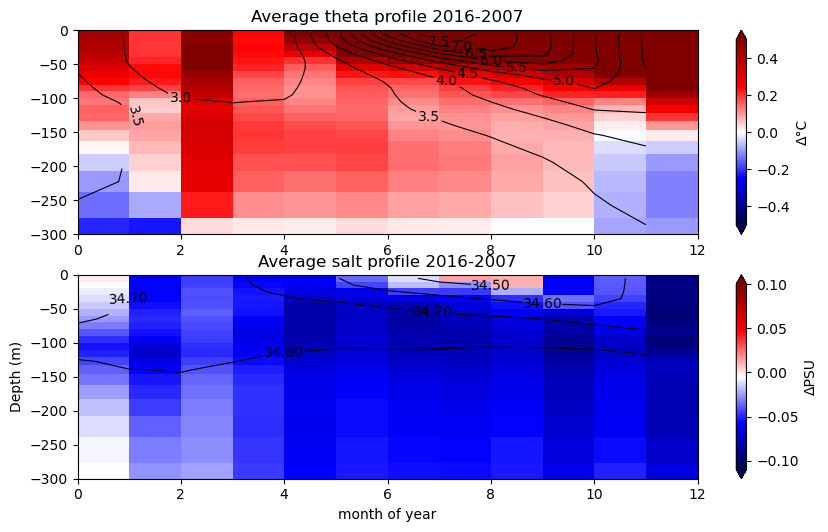

In [64]:
# try to add these as a plot
fig = plt.figure(figsize=(10,9))
XVc,YVc = np.meshgrid(np.arange(13),mygrid['RF'])



# temperature profile average
ax = plt.subplot(311)
cb = ax.pcolormesh(XVc, YVc, thetaprofile[:,12:] - thetaprofile[:,:12],cmap='seismic',vmin=-.5,vmax=.5)
cs = ax.contour(XVc1, YVc1, theta_mean, colors='k', linewidths=0.8,levels = np.arange(1,8,.5))
ax.clabel(cs, fmt="%.1f")
ax.set_ylim(-300,0)
ax.set_title("Average theta profile 2016-2007")
plt.colorbar(cb,extend="both",label="Δ°C")

# salt profile average
ax = plt.subplot(312)
cb = ax.pcolormesh(XVc, YVc, saltprofile[:,12:] - saltprofile[:,:12],cmap='seismic',vmin=.1,vmax=-.1)
cs = ax.contour(XVc1, YVc1, salt_mean, colors='k', linewidths=0.8,levels = np.arange(34.5,35,.1))
ax.clabel(cs, fmt="%.2f")
ax.set_ylim(-300,0)
ax.set_title("Average salt profile 2016-2007")
plt.colorbar(cb,extend="both",label="ΔPSU")

plt.xlabel("month of year")
plt.ylabel("Depth (m)")

In [65]:
# Define dimensions
num_years = len(allyears)  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ","NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Initialize dictionaries with variable-length arrays for each gate
theta_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
salt_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}

iy = 0  # Counter for year index

for year in allyears:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    THETA_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    SALT_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "state_3d_set1"
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["THETA", "SALT"]]

        read = [int(tsstr[i])]
        THETAi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[0])
        SALTi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[1])

        THETA_all[i, :, :, :] = np.reshape(THETAi, (nz, ny, nx))
        SALT_all[i, :, :, :] = np.reshape(SALTi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        #print(y_idx)
        for depth in range(nz):
            theta_timeseries[gate][iy, :, depth, :] = THETA_all[:, depth, y_idx, x_idx]
            salt_timeseries[gate][iy, :, depth, :] = SALT_all[:, depth, y_idx, x_idx]

    iy += 1  # Move to the next year


Processing year: 2007
Processing year: 2016


In [66]:
# Define dimensions
choose_UV_bso3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_bso,x_bso):
    choose_UV_bso3d[:,i,j] = np.full(nz,choose_UV_bso[idx])
    idx += 1

choose_UV_sfj3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_sfj,x_sfj):
    choose_UV_sfj3d[:,i,j] = np.full(nz,choose_UV_sfj[idx])
    idx += 1

choose_UV_fjnz3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_fjnz,x_fjnz):
    choose_UV_fjnz3d[:,i,j] = np.full(nz,choose_UV_fjnz[idx])
    idx += 1

choose_UV_nzru3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_nzru,x_nzru):
    choose_UV_nzru3d[:,i,j] = np.full(nz,choose_UV_nzru[idx])
    idx += 1

num_years = len(allyears)  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ", "NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Selection dictionary for horizontal (ADVx_TH) or vertical (ADVy_TH) transport
choose_UV = {"BSO": choose_UV_bso3d, "SFJ": choose_UV_sfj3d, "FJNZ": choose_UV_fjnz3d, "NZRU": choose_UV_nzru3d}

# Initialize dictionary to store heat transport for each gate
heat_transport_timeseries = {
    gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()
}

iy = 0  # Counter for year index

for year in allyears:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    ADVx_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    ADVy_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "budg3d_hflux_set2"
        meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["ADVx_TH", "ADVy_TH"]]

        read = [int(tsstr[i])]
        ADVx_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[0])
        ADVy_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[1])

        ADVx_TH_all[i, :, :, :] = np.reshape(ADVx_THi, (nz, ny, nx))
        ADVy_TH_all[i, :, :, :] = np.reshape(ADVy_THi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        UV_selection = choose_UV[gate]  # Determine whether to use H (ADVx_TH) or V (ADVy_TH)
        
        for depth in range(nz):
            advx_seasonal = myparms["rcp"] * ADVx_TH_all[:, depth, y_idx, x_idx]
            advy_seasonal = myparms["rcp"] * ADVy_TH_all[:, depth, y_idx, x_idx]
            
            # Use np.where() for per-gridpoint selection
            if gate == "BSO":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", advx_seasonal, -advy_seasonal)
            elif gate == "SFJ":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)
            else:
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)

            heat_transport_timeseries[gate][iy, :, depth, :] = adv_selected


    iy += 1  # Move to the next year

NameError: name 'choose_UV_bso' is not defined

In [68]:
# Compute distances dynamically for each gate
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

gate_distances = {}

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_bso, y_bso, choose_UV_bso), 
                                                                (x_sfj, y_sfj, choose_UV_sfj), 
                                                                (x_fjnz, y_fjnz, choose_UV_fjnz),
                                                                (x_nzru, y_nzru, choose_UV_nzru)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

In [69]:
# do averaging by years and months

theta_avg = {gate: np.nanmean(theta_timeseries[gate][:,3:8,:,:], axis=(1)) for gate in gate_labels}
salt_avg  = {gate: np.nanmean(salt_timeseries[gate][:,3:8,:,:], axis=(1))  for gate in gate_labels}

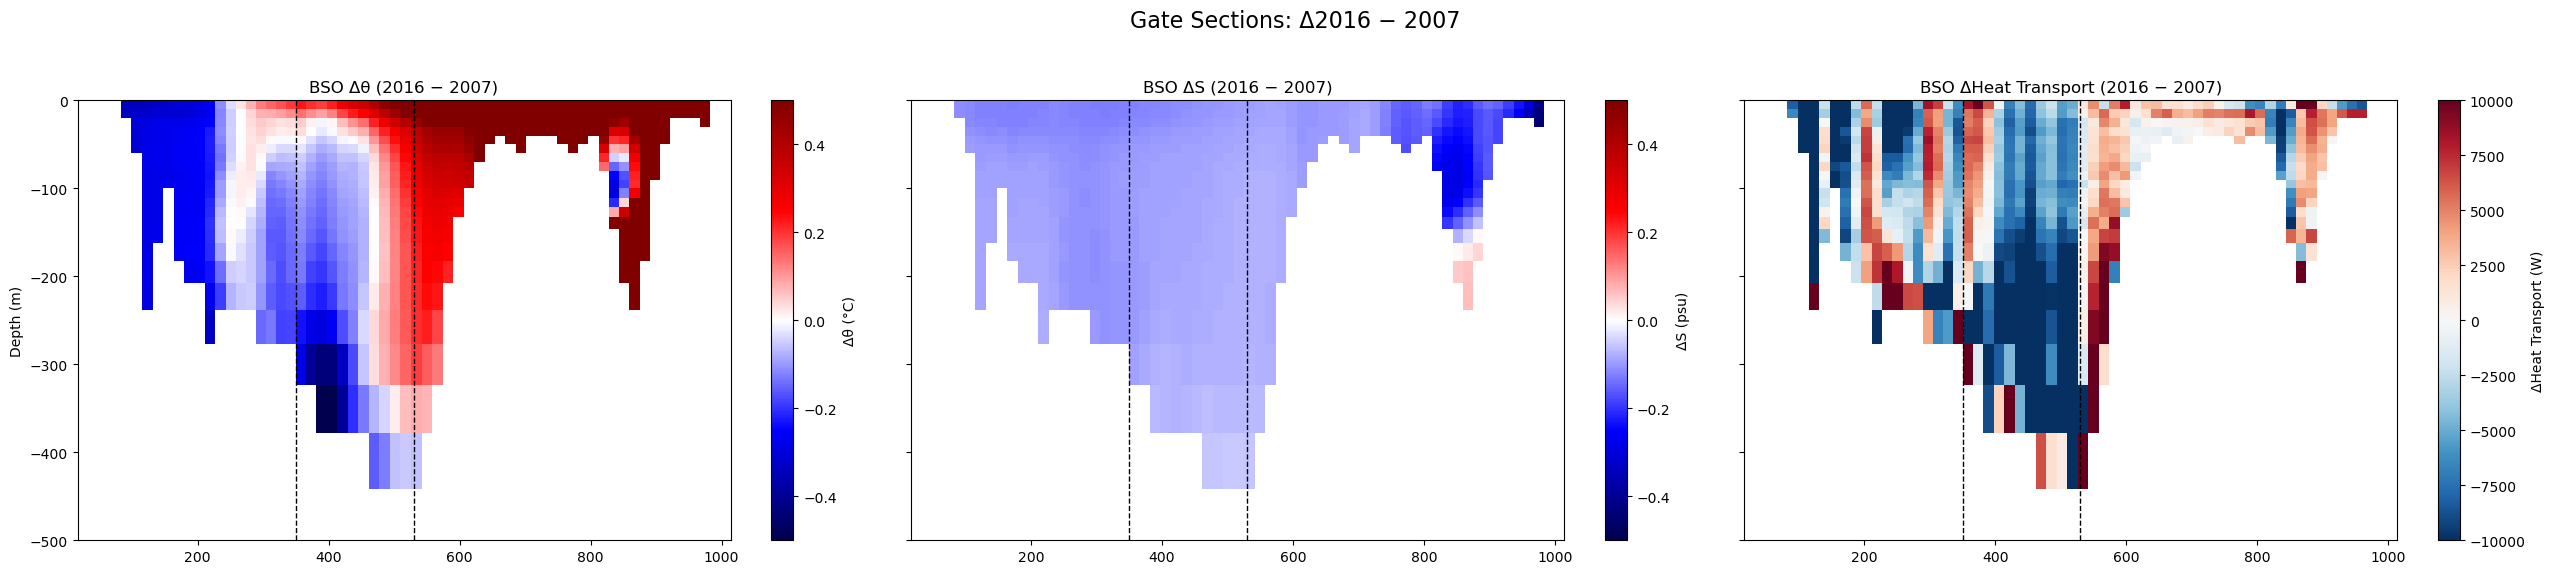

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(26, 6), sharey=True)
gate_labels = ["BSO"]

x_vals = {gate: gate_distances[gate] for gate in gate_labels}
y_vals = np.cumsum(-mygrid['DRF'])  # vertical coordinates

for gate in gate_labels:
    X_center = x_vals[gate]
    Y_center = y_vals

    # Construct edges for pcolormesh
    x_edges = np.concatenate([X_center, [X_center[-1] + (X_center[-1] - X_center[-2])]])
    y_edges = np.concatenate([[0], Y_center])

    # --- Temperature and salinity anomalies (2016 - 2007) ---
    theta = theta_avg[gate][1] - theta_avg[gate][0]
    theta[theta == 0] = np.nan
    salt = salt_avg[gate][1] - salt_avg[gate][0]
    salt[salt == 0] = np.nan

    # --- Heat transport difference (2016 - 2007) in Watts ---
    ht16 = np.nanmean(heat_transport_timeseries16[gate][0], axis=0)  # [nz, nfaces]
    ht07 = np.nanmean(heat_transport_timeseries07[gate][0], axis=0)
    dht = ht16 - ht07  # W (or adjust scaling to TW, PW, etc.)
    dht[dht == 0] = np.nan

    # θ subplot
    im1 = axes[0].pcolormesh(x_edges, y_edges, theta, cmap='seismic', vmin=-.5,vmax=0.5)
    axes[0].set_title(f"{gate} Δθ (2016 − 2007)")
    axes[0].set_ylim(-500, 0)
    axes[0].set_ylabel("Depth (m)")
    fig.colorbar(im1, ax=axes[0], orientation='vertical', label='Δθ (°C)')
    axes[0].axvline(350, color="k", linestyle="--", linewidth=1)
    axes[0].axvline(530, color="k", linestyle="--", linewidth=1)

    # S subplot
    im2 = axes[1].pcolormesh(x_edges, y_edges, salt, cmap='seismic', vmin=-.5,vmax=0.5)
    axes[1].set_title(f"{gate} ΔS (2016 − 2007)")
    axes[1].set_ylim(-500, 0)
    fig.colorbar(im2, ax=axes[1], orientation='vertical', label='ΔS (psu)')
    axes[1].axvline(350, color="k", linestyle="--", linewidth=1)
    axes[1].axvline(530, color="k", linestyle="--", linewidth=1)

    # Heat transport subplot
    im3 = axes[2].pcolormesh(x_edges, y_edges, dht, cmap='RdBu_r', shading='auto',vmin=-1e4,vmax=1e4)
    # im3 = axes[2].pcolormesh(x_edges, y_edges, ht16, cmap='seismic', shading='auto',vmin=-1e5,vmax=1e5)
    axes[2].set_title(f"{gate} ΔHeat Transport (2016 − 2007)")
    axes[2].set_ylim(-500, 0)
    fig.colorbar(im3, ax=axes[2], orientation='vertical', label='ΔHeat Transport (W)')
    axes[2].axvline(350, color="k", linestyle="--", linewidth=1)
    axes[2].axvline(530, color="k", linestyle="--", linewidth=1)

fig.suptitle("Gate Sections: Δ2016 − 2007", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig("story/gates_fluidcolorbar.png", dpi=300)
plt.show()


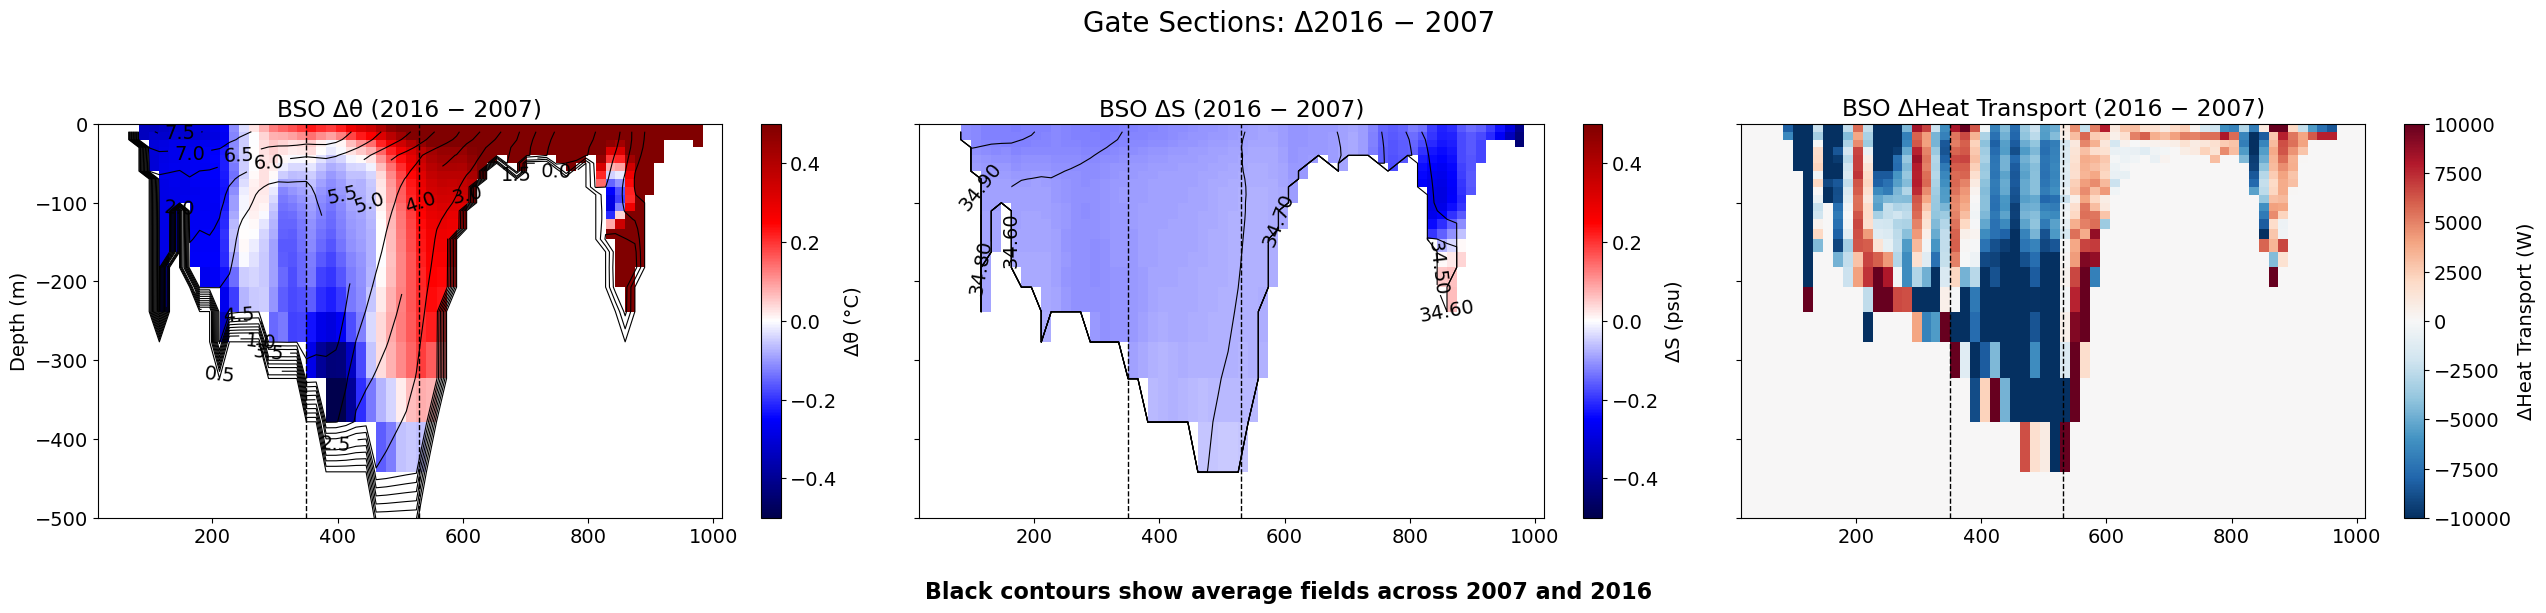

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# bump font size globally
plt.rcParams.update({"font.size": 14})

fig, axes = plt.subplots(1, 3, figsize=(26, 6), sharey=True)
gate_labels = ["BSO"]

x_vals = {gate: gate_distances[gate] for gate in gate_labels}
y_vals = np.cumsum(-mygrid['DRF'])  # vertical coordinates (cell centers)

for gate in gate_labels:
    X_center = x_vals[gate]
    Y_center = y_vals

    # Construct edges for pcolormesh
    x_edges = np.concatenate([X_center, [X_center[-1] + (X_center[-1] - X_center[-2])]])
    y_edges = np.concatenate([[0], Y_center])

    # --- Temperature and salinity anomalies (2016 - 2007) ---
    theta16, theta07 = theta_avg[gate][1], theta_avg[gate][0]
    salt16,  salt07  = salt_avg[gate][1],  salt_avg[gate][0]

    theta = theta16 - theta07
    salt  = salt16 - salt07

    # mask zeros & NaNs
    theta = np.ma.masked_invalid(np.where(theta == 0, np.nan, theta))
    salt  = np.ma.masked_invalid(np.where(salt == 0, np.nan, salt))

    # averages for contours
    theta_mean = np.ma.masked_invalid(0.5 * (theta16 + theta07))
    salt_mean  = np.ma.masked_invalid(0.5 * (salt16 + salt07))

    # --- Heat transport difference (2016 - 2007) in Watts ---
    ht16 = np.nanmean(heat_transport_timeseries16[gate][0], axis=0)  # [nz, nfaces]
    ht07 = np.nanmean(heat_transport_timeseries07[gate][0], axis=0)
    dht = ht16 - ht07
    dht = np.ma.masked_invalid(np.where(dht == 0, 0, dht))

    ht_mean = np.ma.masked_invalid(0.5 * (ht16 + ht07))

    # θ subplot
    im1 = axes[0].pcolormesh(x_edges, y_edges, theta, cmap='seismic', vmin=-.5, vmax=.5)
    cs1 = axes[0].contour(X_center, Y_center, theta_mean,
                          colors='k', linewidths=0.8, levels=np.arange(-2, 8, 0.5))
    axes[0].clabel(cs1, fmt="%.1f")
    axes[0].set_title(f"{gate} Δθ (2016 − 2007)")
    axes[0].set_ylim(-500, 0)
    axes[0].set_ylabel("Depth (m)")
    fig.colorbar(im1, ax=axes[0], orientation='vertical', label='Δθ (°C)')
    axes[0].axvline(350, color="k", linestyle="--", linewidth=1)
    axes[0].axvline(530, color="k", linestyle="--", linewidth=1)

    # S subplot
    im2 = axes[1].pcolormesh(x_edges, y_edges, salt, cmap='seismic', vmin=-.5, vmax=.5)
    cs2 = axes[1].contour(X_center, Y_center, salt_mean,
                          colors='k', linewidths=0.8, levels=np.arange(34.5, 35.5, 0.1))
    axes[1].clabel(cs2, fmt="%.2f")
    axes[1].set_title(f"{gate} ΔS (2016 − 2007)")
    axes[1].set_ylim(-500, 0)
    fig.colorbar(im2, ax=axes[1], orientation='vertical', label='ΔS (psu)')
    axes[1].axvline(350, color="k", linestyle="--", linewidth=1)
    axes[1].axvline(530, color="k", linestyle="--", linewidth=1)

    # Heat transport subplot
    im3 = axes[2].pcolormesh(x_edges, y_edges, dht, cmap='RdBu_r',
                             shading='auto', vmin=-1e4, vmax=1e4)
    axes[2].set_title(f"{gate} ΔHeat Transport (2016 − 2007)")
    axes[2].set_ylim(-500, 0)
    fig.colorbar(im3, ax=axes[2], orientation='vertical', label='ΔHeat Transport (W)')
    axes[2].axvline(350, color="k", linestyle="--", linewidth=1)
    axes[2].axvline(530, color="k", linestyle="--", linewidth=1)

# global label for contours
fig.text(0.5, 0.01,
         "Black contours show average fields across 2007 and 2016",
         ha='center', va='center', fontsize=16, fontweight='bold')

fig.suptitle("Gate Sections: Δ2016 − 2007", fontsize=20)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


### I think we still want to figure out what is causing the contraction in January for high T and high S
#### My thinking is that this is the difference in the properties of the inflow AW but I'm not sure

In [74]:
# Let's look at the average properties of the inflow through this section.
# maybe we can take a slice at the BSO for JFM and look at the TS-distribution scatter plot

In [80]:
# theta_timeseries07
# salt_timeseries07
# theta_timeseries16
# salt_timeseries16

In [104]:
AWinflow = np.where((gate_distances['BSO'] < 565) & (gate_distances['BSO'] > 335))
a,b = AWinflow[0][0],AWinflow[0][-1]
d_sel = np.where(np.cumsum(mygrid['DRF']) > 100)
d_sel = d_sel[0][0]

<a list of 29 text.Text objects>

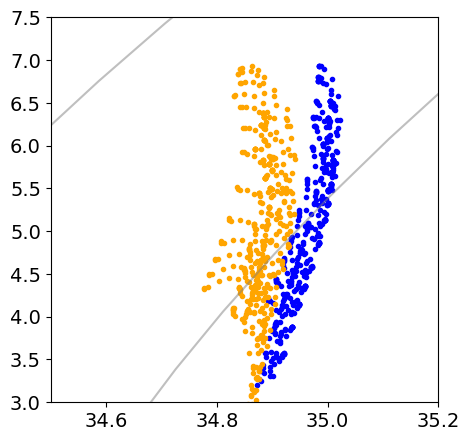

In [120]:
# let's figure out which indices we want by the location along the gate
# gate_distances['BSO'][21:35]
# let's also do the depth below the surface (k = 10+)  this will be 100m+
# can possibly just do a scatter plot of these inflow values

thetas = theta_timeseries['BSO'][:,:3,:,:]   # theta for JFM
salts = salt_timeseries['BSO'][:,:3,:,:]

theta_07_sample = thetas[0,:,d_sel:,a:b]  # select theta for this time; JFM, depth term, length along gate
salt_07_sample = salts[0,:,d_sel:,a:b]
theta_16_sample = thetas[1,:,d_sel:,a:b]
salt_16_sample = salts[1,:,d_sel:,a:b]

fig = plt.figure(figsize = (5,5))

plt.scatter(salt_07_sample.flatten(),theta_07_sample.flatten(),marker=".",color="blue")
plt.scatter(salt_16_sample.flatten(),theta_16_sample.flatten(),marker=".",color="orange")
plt.xlim(34.5,35.2)
plt.ylim(3,7.5)
# density contours
cs = plt.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5,
                levels=np.arange(16, 32, .5))
plt.clabel(cs, fontsize=9, inline=False, fmt="%.0f")


# print(thetas.shape)